### Imports

In [0]:
# ! pip install seqeval
import warnings
warnings.filterwarnings('ignore')
import string 
import re
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
import itertools
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

### Download data

In [3]:
# get Annotated Corpus for Named Entity Recognition 
!wget https://github.com/RufinaMay/CV2019Fall_Pictures/blob/master/ner_dataset.csv?raw=true -O ner_dataset.csv
# get Broad Twitter
!git clone https://github.com/GateNLP/broad_twitter_corpus.git

--2019-12-06 19:11:42--  https://github.com/RufinaMay/CV2019Fall_Pictures/blob/master/ner_dataset.csv?raw=true
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/RufinaMay/CV2019Fall_Pictures/raw/master/ner_dataset.csv [following]
--2019-12-06 19:11:43--  https://github.com/RufinaMay/CV2019Fall_Pictures/raw/master/ner_dataset.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/RufinaMay/CV2019Fall_Pictures/master/ner_dataset.csv [following]
--2019-12-06 19:11:43--  https://raw.githubusercontent.com/RufinaMay/CV2019Fall_Pictures/master/ner_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.1

## Load and preprocess the Broad Twitter
Convert to indexes and split on train and test

In [12]:
unique_tags = set()
unique_words = set()

def load_file(path):
  f = open(path)
  line = f.readline()
  regex = re.compile('[^a-zA-Z]')
  data = []
  sent, tags = [], []
  while line:
    try: 
      word, tag = line.split()
      word = regex.sub(' ', word)
      if len(word)>0:
        word = word.lower()
        sent.append(word)
        tags.append(tag)
        unique_tags.add(tag)
        unique_words.add(word)
    except: 
      data.append((sent, tags))
      sent, tags = [], []
    line = f.readline()
  f.close()
  return data

# load test data
test_data = load_file('broad_twitter_corpus/h.conll')

# keep half for training data and half to test data
train_data = test_data[100:]
test_data = test_data[:100]
print(len(test_data))

# load train data
paths_to_train = ['broad_twitter_corpus/a.conll', 'broad_twitter_corpus/b.conll', 'broad_twitter_corpus/e.conll',
                  'broad_twitter_corpus/f.conll', 'broad_twitter_corpus/g.conll']

for path in paths_to_train:
  data = load_file(path)
  for sent in data:
    train_data.append(sent)

print(f'test samples {len(test_data)}')
print(f'train samples {len(train_data)}')
print(len(unique_words))

# index words and tags
word_to_idx = {k:i for i, k in enumerate(unique_words)}
tag_to_idx = {k:i for i, k in enumerate(unique_tags)}
tag_to_idx['START'] = len(tag_to_idx)
tag_to_idx['END'] = len(tag_to_idx)
print(tag_to_idx)

# convert train sentences and tags to indexes
indexed_train = []
for sent, tags in train_data:
  indexed_sent = [word_to_idx[word] for word in sent ]
  indexed_tags = [tag_to_idx[tag] for tag in tags]
  indexed_train.append((indexed_sent, indexed_tags))

# split data on train and validation sets
indexed_train, indexed_validation = train_test_split(indexed_train, test_size = 0.3, shuffle = True)
print(f'train size: {len(indexed_train)}')
print(f'valid size: {len(indexed_validation)}')

# index test set as well
indexed_test = []
for sent, tags in test_data:
  indexed_sent = [word_to_idx[word] for word in sent ]
  indexed_tags = [tag_to_idx[tag] for tag in tags]
  indexed_test.append((indexed_sent, indexed_tags))

index_to_tag = {tag_to_idx[k]:k for k in tag_to_idx }

100
test samples 100
train samples 9251
27160
{'I-PER': 0, 'B-PER': 1, 'B-LOC': 2, 'I-LOC': 3, 'B-ORG': 4, 'O': 5, 'I-ORG': 6, 'START': 7, 'END': 8}
train size: 6475
valid size: 2776


### Load and preprocess Annotated Corpusfor Named Entity Recognition

In [13]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data = data.fillna(method="ffill")
words = list(set(data['Word'].values))
tags = list(set(data['Tag'].values))

print(f'Sentences: {len(data.groupby(["Sentence #"]))}')
print(f'Words: {len(words)}')
print(f'Tags: {len(tags)}')

words_set = set()
regex = re.compile('[^a-zA-Z]')
for word in words:
  word = regex.sub(' ', word)
  if len(word)>0:
    word = word.lower()
    words_set.add(word)
words = words_set

word_to_idx_2 = {word:i for i, word in enumerate(words)}
tag_to_idx_2 = {tag:i for i, tag in enumerate(tags) }
tag_to_idx_2['START'] = len(tag_to_idx_2)
tag_to_idx_2['END'] = len(tag_to_idx_2)
print(tag_to_idx_2)

# convert data to indexes
indexed_data2 = []
agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                              s["Tag"].values.tolist())]
grouped = data.groupby("Sentence #").apply(agg_func)
sentences = [s for s in grouped]
for sent in sentences:
  indexed_sent, indexed_tags = [], []
  for w, t in sent:
    if w.lower() in word_to_idx_2:
      indexed_sent.append(word_to_idx_2[w.lower()])
      indexed_tags.append(tag_to_idx_2[t])
  indexed_data2.append((indexed_sent, indexed_tags))

# split on train, validation and test sets
train2, test2 = train_test_split(indexed_data2, test_size = 0.3)
train2, validation2 = train_test_split(indexed_data2, test_size = 0.3)
print(f'train size: {len(train2)}')
print(f'validation size: {len(validation2)}')
print(f'test size: {len(test2)}')

Sentences: 47959
Words: 35178
Tags: 17
{'I-art': 0, 'I-geo': 1, 'B-gpe': 2, 'B-nat': 3, 'I-per': 4, 'I-eve': 5, 'B-eve': 6, 'I-tim': 7, 'B-per': 8, 'B-org': 9, 'O': 10, 'B-art': 11, 'I-gpe': 12, 'I-nat': 13, 'B-tim': 14, 'B-geo': 15, 'I-org': 16, 'START': 17, 'END': 18}
train size: 33571
validation size: 14388
test size: 14388


### Pytorch implementation

In [0]:
def argmax(vec):
    _, idx = torch.max(vec, 1)
    return idx.item()

def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [0]:
class BiLSTM_CRF(nn.Module):
  def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
      super(BiLSTM_CRF, self).__init__()
      self.embedding_dim = embedding_dim
      self.hidden_dim = hidden_dim
      self.vocab_size = vocab_size
      self.tag_to_ix = tag_to_ix
      self.tagset_size = len(tag_to_ix)

      self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
      self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                          num_layers=1, bidirectional=True)

      # Maps the output of the LSTM into tag space.
      self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

      # Matrix of transition parameters.  Entry i,j is the score of
      # transitioning *to* i *from* j.
      self.transitions = nn.Parameter(
          torch.randn(self.tagset_size, self.tagset_size))

      # These two statements enforce the constraint that we never transfer
      # to the start tag and we never transfer from the stop tag
      self.transitions.data[tag_to_ix['START'], :] = -10000
      self.transitions.data[:, tag_to_ix['END']] = -10000

      self.hidden = self.init_hidden()

  def init_hidden(self):
      return (torch.randn(2, 1, self.hidden_dim // 2),
              torch.randn(2, 1, self.hidden_dim // 2))

  def _forward_alg(self, feats):
      # Do the forward algorithm to compute the partition function
      init_alphas = torch.full((1, self.tagset_size), -10000.)
      # START_TAG has all of the score.
      init_alphas[0][self.tag_to_ix['START']] = 0.

      # Wrap in a variable so that we will get automatic backprop
      forward_var = init_alphas

      # Iterate through the sentence
      for feat in feats:
          alphas_t = []  # The forward tensors at this timestep
          for next_tag in range(self.tagset_size):
              # broadcast the emission score: it is the same regardless of
              # the previous tag
              emit_score = feat[next_tag].view(
                  1, -1).expand(1, self.tagset_size)
              # the ith entry of trans_score is the score of transitioning to
              # next_tag from i
              trans_score = self.transitions[next_tag].view(1, -1)
              # The ith entry of next_tag_var is the value for the
              # edge (i -> next_tag) before we do log-sum-exp
              next_tag_var = forward_var + trans_score + emit_score
              # The forward variable for this tag is log-sum-exp of all the
              # scores.
              alphas_t.append(log_sum_exp(next_tag_var).view(1))
          forward_var = torch.cat(alphas_t).view(1, -1)
      terminal_var = forward_var + self.transitions[self.tag_to_ix['END']]
      alpha = log_sum_exp(terminal_var)
      return alpha

  def _get_lstm_features(self, sentence):
      self.hidden = self.init_hidden()
      embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
      lstm_out, self.hidden = self.lstm(embeds, self.hidden)
      lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
      lstm_feats = self.hidden2tag(lstm_out)
      return lstm_feats

  def _score_sentence(self, feats, tags):
      # Gives the score of a provided tag sequence
      score = torch.zeros(1)
      tags = torch.cat([torch.tensor([self.tag_to_ix['START']], dtype=torch.long), tags])
      for i, feat in enumerate(feats):
          score = score + \
              self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
      score = score + self.transitions[self.tag_to_ix['END'], tags[-1]]
      return score

  def _viterbi_decode(self, feats):
      backpointers = []

      # Initialize the viterbi variables in log space
      init_vvars = torch.full((1, self.tagset_size), -10000.)
      init_vvars[0][self.tag_to_ix['START']] = 0

      # forward_var at step i holds the viterbi variables for step i-1
      forward_var = init_vvars
      for feat in feats:
          bptrs_t = []  # holds the backpointers for this step
          viterbivars_t = []  # holds the viterbi variables for this step

          for next_tag in range(self.tagset_size):
              # next_tag_var[i] holds the viterbi variable for tag i at the
              # previous step, plus the score of transitioning
              # from tag i to next_tag.
              # We don't include the emission scores here because the max
              # does not depend on them (we add them in below)
              next_tag_var = forward_var + self.transitions[next_tag]
              best_tag_id = argmax(next_tag_var)
              bptrs_t.append(best_tag_id)
              viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
          # Now add in the emission scores, and assign forward_var to the set
          # of viterbi variables we just computed
          forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
          backpointers.append(bptrs_t)

      # Transition to STOP_TAG
      terminal_var = forward_var + self.transitions[self.tag_to_ix['END']]
      best_tag_id = argmax(terminal_var)
      path_score = terminal_var[0][best_tag_id]

      # Follow the back pointers to decode the best path.
      best_path = [best_tag_id]
      for bptrs_t in reversed(backpointers):
          best_tag_id = bptrs_t[best_tag_id]
          best_path.append(best_tag_id)
      # Pop off the start tag (we dont want to return that to the caller)
      start = best_path.pop()
      assert start == self.tag_to_ix['START']  # Sanity check
      best_path.reverse()
      return path_score, best_path

  def neg_log_likelihood(self, sentence, tags):
      feats = self._get_lstm_features(sentence)
      forward_score = self._forward_alg(feats)
      gold_score = self._score_sentence(feats, tags)
      return forward_score - gold_score

  def forward(self, sentence):  # dont confuse this with _forward_alg above.
      # Get the emission scores from the BiLSTM
      lstm_feats = self._get_lstm_features(sentence)

      # Find the best path, given the features.
      score, tag_seq = self._viterbi_decode(lstm_feats)
      return tag_seq

## Training on Broad Twitter Corpus 
First lets see if model is able to learn something without transfer learning

In [0]:
def compute_f1(true, predicted):
  f1 = {}
  for tag in tag_to_idx:
    idx = np.where(true == tag_to_idx[tag])
    true_tag = np.zeros(len(true))
    true_tag[idx] = 1
    idx = np.where(true == tag_to_idx[tag])
    predicted_tag = np.zeros(len(predicted))
    predicted_tag[idx] = 1
    score = f1_score(true_tag, predicted_tag)
    f1[tag] = score
  return f1


def train_epoch(sentence, tags, training = True):
  if training:
    model.train()
  else:
    model.eval()
  model.zero_grad()
  optimizer.zero_grad()
  sentence_in = torch.tensor(sentence, dtype=torch.long)
  targets = torch.tensor(tags, dtype=torch.long)
  loss = model.neg_log_likelihood(sentence_in, targets)
  if training:
    loss.backward()
    optimizer.step()
  # compute metrics
  return loss.item(), model(sentence_in)
  
def train(train_data, validation_data, epochs = 10):
  t_loss_plot, v_loss_plot = [], []
  t_f1_overall_plot, v_f1_overall_plot = [], []
  for e in range(epochs):
    T_loss, V_loss = [], []
    T_true, T_pred, V_true, V_pred = [], [], [], []
    for sentence, tags in train_data:
      if len(sentence) <1:
        continue
      t_out = train_epoch(sentence, tags)
      T_loss.append(t_out[0])
      T_true.extend(tags), T_pred.extend(t_out[1])
    train_f1 = f1_score(T_true, T_pred, average='macro')
    train_f1_per_class = compute_f1(T_true, T_pred)
    # validation step
    for sentence, tags in validation_data:
      if len(sentence) <1:
        continue
      v_out = train_epoch(sentence, tags, training = False)
      V_loss.append(v_out[0]), V_true.extend(tags), V_pred.extend(v_out[1])
    valid_f1 = f1_score(V_true, V_pred, average='macro')
    valid_f1__per_class = compute_f1(V_true, V_pred)
    
    # for making plots at the end
    t_loss_plot.append(np.mean(T_loss)), v_loss_plot.append(np.mean(V_loss))
    t_f1_overall_plot.append(train_f1), v_f1_overall_plot.append(valid_f1)

    print(f'epoch {e} tr loss {np.mean(T_loss)} val loss {np.mean(V_loss)} tr f1 {train_f1} val f1 {valid_f1}')
    print('===================== Train per class F1 score ==============================')
    print(classification_report(T_true, T_pred))
    print('===================== Valid per class F1 score ==============================')
    print( classification_report(V_true, V_pred) )

  return t_loss_plot, v_loss_plot, t_f1_overall_plot, v_f1_overall_plot

In [0]:
model = BiLSTM_CRF(len(word_to_idx), tag_to_idx, embedding_dim = 100, hidden_dim = 32)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

out = train(indexed_train, indexed_validation)

epoch 0 tr loss 6.498764228909281 val loss 5.412286903984573 tr f1 0.2170148086568491 val f1 0.3098017690614565
===================== Train per class F1 score ==============================
              precision    recall  f1-score   support

           0       0.55      0.03      0.06      1102
           1       0.70      0.16      0.26      5498
           2       0.82      0.04      0.07      1992
           3       0.89      1.00      0.94     91615
           4       0.78      0.05      0.09       824
           5       0.89      0.04      0.09      2911
           6       1.00      0.01      0.01       667

    accuracy                           0.88    104609
   macro avg       0.80      0.19      0.22    104609
weighted avg       0.87      0.88      0.84    104609

===================== Valid per class F1 score ==============================
              precision    recall  f1-score   support

           0       0.35      0.06      0.10       438
           1       0.48   

### Plot Trainig process on Broad Twitter Corpus 

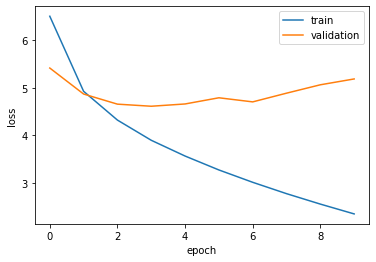

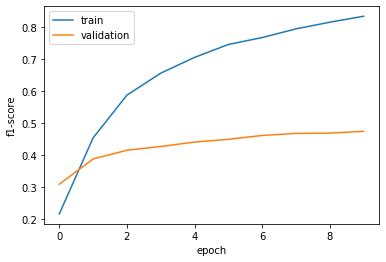

In [0]:
plt.plot(out[0], label = 'train')
plt.plot(out[1], label = 'validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(out[2], label = 'train')
plt.plot(out[3], label = 'validation')
plt.xlabel('epoch')
plt.ylabel('f1-score')
plt.legend()
plt.show()

### Calculate metrics on test set of Broad Twitter Corpus 

In [0]:
T_true, T_pred = [], []
for sentence, tags in indexed_test:
    if len(sentence) <1:
      continue
    sentence_in = torch.tensor(sentence, dtype=torch.long)
    prediction = model(sentence_in)
    T_true.extend(tags), T_pred.extend(prediction)

test_f1 = f1_score(T_true, T_pred, average='macro')
print('Evaluating on test set')
print(f'overall f1: {test_f1}')
print(classification_report(T_true, T_pred))

Evaluating on test set
overall f1: 0.3721372571175189
              precision    recall  f1-score   support

           0       0.60      0.43      0.50        14
           1       0.59      0.49      0.53       104
           2       0.56      0.42      0.48        12
           3       0.94      0.97      0.95      1274
           4       0.00      0.00      0.00         4
           5       0.16      0.12      0.14        40
           6       0.00      0.00      0.00         1

    accuracy                           0.90      1449
   macro avg       0.41      0.35      0.37      1449
weighted avg       0.89      0.90      0.89      1449



### Pretraining on Annotated Corpus

In [0]:
model = BiLSTM_CRF(len(word_to_idx_2), tag_to_idx_2, embedding_dim = 100, hidden_dim = 32)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

out = train(train2, validation2, epochs = 1)

In [0]:
# save pretrained model
torch.save(model.state_dict(), 'trained_model_state_dict3')
torch.save(model, 'trained_model_itself3')

### Plot training process of pretraining on Annotated Corpus

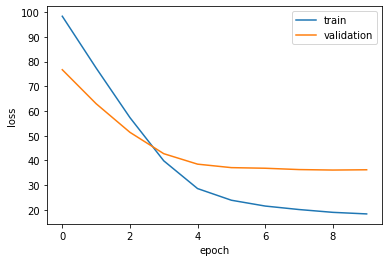

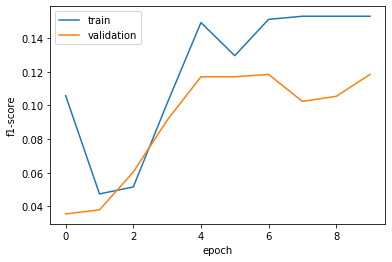

In [0]:
plt.plot(out[0], label = 'train')
plt.plot(out[1], label = 'validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(out[2], label = 'train')
plt.plot(out[3], label = 'validation')
plt.xlabel('epoch')
plt.ylabel('f1-score')
plt.legend()
plt.show()

### Asses on test of Annotated Corpus

In [0]:
T_true, T_pred = [], []
for sentence, tags in indexed_test:
    if len(sentence) <1:
      continue
    sentence_in = torch.tensor(sentence, dtype=torch.long)
    prediction = model(sentence_in)
    T_true.extend(tags), T_pred.extend(prediction)

test_f1 = f1_score(T_true, T_pred, average='macro')
print('Evaluating on test set')
print(f'overall f1: {test_f1}')
print(classification_report(T_true, T_pred))

Evaluating on test set
overall f1: 0.0037883733383975303
              precision    recall  f1-score   support

           0       0.00      0.17      0.01        12
           1       0.00      0.00      0.00      1274
           2       0.02      0.25      0.03        40
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0

    accuracy                           0.01      1449
   macro avg       0.00      0.04      0.00      1449
weighted avg       0.00      0.01      0.00      1449



### Load pretrained model and continue training on Broad Twitter Corpus

In [9]:
the_model = torch.load('/content/trained_model_itself3')

model = BiLSTM_CRF(len(word_to_idx), tag_to_idx, embedding_dim = 100, hidden_dim = 32)
model.lstm = the_model.lstm
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

out = train(indexed_train, indexed_validation)

NameError: ignored

### Plot training process

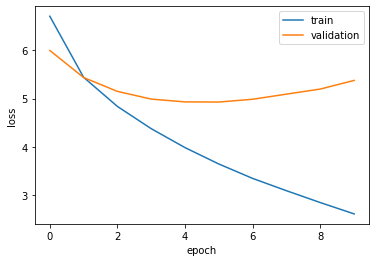

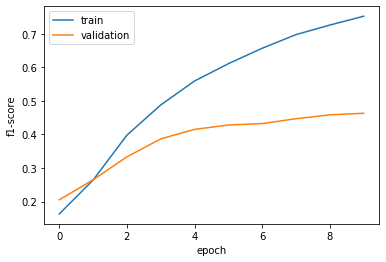

In [21]:
plt.plot(out[0], label = 'train')
plt.plot(out[1], label = 'validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(out[2], label = 'train')
plt.plot(out[3], label = 'validation')
plt.xlabel('epoch')
plt.ylabel('f1-score')
plt.legend()
plt.show()

### Test set performance

In [41]:
T_true, T_pred = [], []
for sentence, tags in indexed_test:
    if len(sentence) <1:
      continue
    sentence_in = torch.tensor(sentence, dtype=torch.long)
    prediction = model(sentence_in)
    T_true.extend(tags), T_pred.extend(prediction)

T_true = [index_to_tag[idx] for idx in T_true ]
T_pred = [index_to_tag[idx] for idx in T_pred ]

test_f1 = f1_score(T_true, T_pred, average='macro')
print('Evaluating on test set')
print(f'overall f1: {test_f1}')
print(classification_report(T_true, T_pred))

Evaluating on test set
overall f1: 0.337369791782416
              precision    recall  f1-score   support

       B-LOC       0.60      0.50      0.55        12
       B-ORG       0.17      0.07      0.10        40
       B-PER       0.62      0.48      0.54       104
       I-LOC       0.00      0.00      0.00         1
       I-ORG       0.00      0.00      0.00         4
       I-PER       0.23      0.21      0.22        14
           O       0.93      0.97      0.95      1274

    accuracy                           0.89      1449
   macro avg       0.36      0.32      0.34      1449
weighted avg       0.88      0.89      0.88      1449



### Common mistakes and correctly predicted tags

In [1]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


index_to_tag = {tag_to_idx[k]:k for k in tag_to_idx }
# make predictions
T_true, T_pred = [], []
for sentence, tags in indexed_test:
    if len(sentence) <1:
      continue
    sentence_in = torch.tensor(sentence, dtype=torch.long)
    prediction = model(sentence_in)
    T_true.extend(tags), T_pred.extend(prediction)

for sentence, tags in indexed_validation:
    if len(sentence) <1:
      continue
    sentence_in = torch.tensor(sentence, dtype=torch.long)
    prediction = model(sentence_in)
    T_true.extend(tags), T_pred.extend(prediction)

# convert predictions from indexes to words
T_true = [index_to_tag[idx] for idx in T_true ]
T_pred = [index_to_tag[idx] for idx in T_pred ]

classes=np.unique(T_true)
cnf_matrix = confusion_matrix(T_true, T_pred,labels=classes)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize = False,
                      title='Confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize = True,
                      title='Normalized confusion matrix')

NameError: ignored